In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import torch


torch.manual_seed(42)
np.random.seed(42)

In [ ]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"CUDA version: {torch.version.cuda}")
print('Device: ', device)

Is CUDA supported by this system? True
CUDA version: 11.3
Device:  cuda


In [ ]:
def permute(expanded,amount):
  return np.array(list(expanded)[amount:len(expanded)]+list(expanded)[0:amount])
  
def mse(prediction,data):
        return np.sqrt(np.mean((prediction - data)**2))

def correct_dimensions(s, targetlength):
    """checks the dimensionality of some numeric argument s, broadcasts it
       to the specified length if possible.
    Args:
        s: None, scalar or 1D array
        targetlength: expected length of s
    Returns:
        None if s is None, else numpy vector of length targetlength
    """
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x


class ESN():

    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 random_state=None, silent=True):
        """
        Args:
            n_inputs: nr of input dimensions
            n_outputs: nr of output dimensions
            n_reservoir: nr of reservoir neurons
            spectral_radius: spectral radius of the recurrent weight matrix
            sparsity: proportion of recurrent weights set to zero
            noise: noise added to each neuron (regularization)
            input_shift: scalar or vector of length n_inputs to add to each
                        input dimension before feeding it to the network.
            input_scaling: scalar or vector of length n_inputs to multiply
                        with each input dimension before feeding it to the netw.
            teacher_forcing: if True, feed the target back into output units
            teacher_scaling: factor applied to the target signal
            teacher_shift: additive term applied to the target signal
            out_activation: output activation function (applied to the readout)
            inverse_out_activation: inverse of the output activation function
            random_state: positive integer seed, np.rand.RandomState object,
                          or None to use numpy's builting RandomState.
            silent: supress messages
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

        self.teacher_forcing = teacher_forcing
        self.silent = silent
        self.initweights()

    def initweights(self):
        # initialize recurrent weights:
        # begin with a random matrix centered around zero:
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        # delete the fraction of connections given by (self.sparsity):
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        # compute the spectral radius of these weights:
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        # rescale them to reach the requested spectral radius:
        self.W = W * (self.spectral_radius / radius)

        # random input weights:
        self.W_in = self.random_state_.rand(
            self.n_reservoir, self.n_inputs) * 2 - 1
        # random feedback (teacher forcing) weights:
        self.W_feedb = self.random_state_.rand(
            self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        """performs one update step.
        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern)
                             + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern))
        return (np.tanh(preactivation)
                + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        """multiplies the teacher/target signal by the teacher_scaling argument,
        then adds the teacher_shift argument to it."""
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        """inverse operation of the _scale_teacher method."""
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, inspect=False):
        """
        Collect the network's reaction to training data, train readout weights.
        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states
        Returns:
            the network's output on the training data, using the trained weights
        """
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        # transform input and teacher signal:
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)

        if not self.silent:
            print("harvesting states...")
        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :],
                                        teachers_scaled[n - 1, :])

        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        if not self.silent:
            print("fitting...")
        # we'll disregard the first few states:
        transient = min(int(inputs.shape[1] / 10), 100)
        # include the raw inputs:
        extended_states = np.hstack((states, inputs_scaled))
        # Solve for W_out:
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]),
                            self.inverse_out_activation(teachers_scaled[transient:, :])).T

        # remember the last state for later:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]

        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        # apply learned weights to the collected states:
        pred_train = self._unscale_teacher(self.out_activation(
            np.dot(extended_states, self.W_out.T)))
        if not self.silent:
            print(np.sqrt(np.mean((pred_train - outputs)**2)))
        return pred_train

    def predict(self, inputs, continuation=True):
        """
        Apply the learned weights to the network's reactions to new input.
        Args:
            inputs: array of dimensions (N_test_samples x n_inputs)
            continuation: if True, start the network from the last training state
        Returns:
            Array of output activations
        """
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(len(lastoutput)-1, n_samples + len(lastoutput)-1):
            states[
                n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out,
                                                           np.concatenate([states[n + 1, :], inputs[n + 1, :]])))

        return self._unscale_teacher(self.out_activation(outputs[1:]))

# Generate Results with Regular ESN

test error: 
0.13960390995820998


Text(0.5, 1.0, 'Dim: 500')

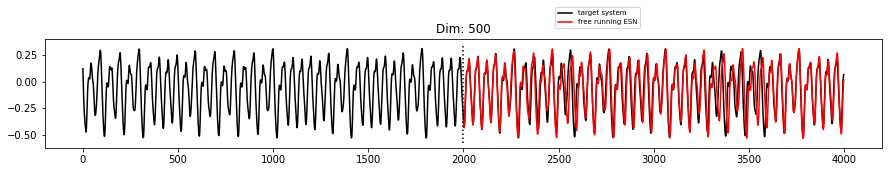

In [ ]:

data = np.load('/content/mackey_glass_t17.npy')
esn = ESN(n_inputs = 1,
          n_outputs = 1,
          n_reservoir = 500,
          spectral_radius = 1.5,
          random_state=42)
trainlen = 2000
future = 2000
pred_training = esn.fit(np.ones(trainlen),data[:trainlen])

prediction = esn.predict(np.ones(future))
print("test error: \n"+str(np.sqrt(np.mean((prediction.flatten() - data[trainlen:trainlen+future])**2))))

plt.figure(figsize=(15,2))
plt.plot(range(0,trainlen+future),data[0:trainlen+future],'k',label="target system")
plt.plot(range(trainlen,trainlen+future),prediction,'r', label="free running ESN")
lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:')
plt.legend(loc=(0.61,1.1),fontsize='x-small')
plt.title('Dim: 500')

# Integer ESN

In [ ]:
def clip(vector, max):
  return torch.clip(vector,-max,max)

# generate a random hypervector of -1 and 1s
def generate_random_hypervector(dim):
    res = torch.randint(low=0, high=2, size=(dim,), device=device).float() # create random 0,1 vector
    res.mul_(2) # makes it 0,2 vector
    res.sub_(1) # makes it -1,1 vector
    return res

def generate_id_matrix(n_features=617, dim=1000):
    res = torch.randint(low=0, high=2, size=(n_features, dim), device=device).float() # create random 0,1 vector
    res.mul_(2) # makes it 0,2 vector
    res.sub_(1) # makes it -1,1 vector
    return res

class Encoder:
    def __init__(self, dim=1000, timestep=1, y_max=1, y_min=0, sensitivity=200):
        self.dim = dim
        self.y_max_hd = generate_random_hypervector(self.dim)
        # self.y_min_hd = generate_random_hypervector(self.dim)
        # mask = np.random.choice(range(self.dim), size=dim//2, replace=False)
        # self.y_max_hd = torch.ones(self.dim).to(device)
        # self.y_max_hd[mask] = -1
        # self.y_min_hd = torch.ones(self.dim).to(device)-2
        self.y_min_hd = -1*self.y_max_hd
        self.y_max = y_max
        self.y_min = y_min
        self.sensitivity = sensitivity
        self.gap = (y_max-y_min) / self.sensitivity
        meta = np.linspace(y_min, y_max, self.sensitivity)
        self.position_hds = generate_id_matrix(timestep, dim)
        self.quantized = torch.zeros((meta.shape[0], self.dim)).to(device)
        for i, val in enumerate(meta):
            self.quantized[i] = self.interpolate(val)
        # self.quantized = generate_id_matrix(self.sensitivity, dim)

    def interpolate(self, val):
        if val >= self.y_max:
            return torch.clone(self.y_max_hd)
        if val <= self.y_min:
            return torch.clone(self.y_min_hd)
        n_from_max = round((val.item() - self.y_min)/(self.y_max - self.y_min)*self.dim)
        # randomly choose "n_from_max" indices to copy from y_max_hd
        indices_from_max = np.random.choice(range(self.dim), size=n_from_max, replace=False)
        hd_vec = torch.clone(self.y_min_hd)
        hd_vec[indices_from_max] = self.y_max_hd[indices_from_max]
        return hd_vec

    def quantized_encode(self, val):
        # return self.interpolate(val)
        ind = max(min(round((val.item() - self.y_min) / self.gap), self.sensitivity-1), 0)
        return self.quantized[ind]

In [ ]:
class intESN():

    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 noise=0.001,
                 random_state=None, silent=True, clip=7, q_in=None, q_out=None):
        """
        Args:
            n_inputs: nr of input dimensions
            n_outputs: nr of output dimensions
            n_reservoir: nr of reservoir neurons
            noise: noise added to each neuron (regularization)
            random_state: positive integer seed, np.rand.RandomState object,
                          or None to use numpy's builting RandomState.
            silent: supress messages
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.noise = noise
        self.silent = silent
        self.clip = clip
        self.out_co = 1
        self.q_in = q_in
        self.q_out = q_out

    def _update(self, state, input_pattern, output_pattern):
        """performs one update step.
        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        preactivation = (torch.roll(state,-1, dims=(0)) # shift state by 1
                          + self.q_in(input_pattern) # hd input
                          + self.out_co * self.q_out(output_pattern)) # hd output
        t = preactivation + self.noise * (torch.rand(self.n_reservoir).to(device) - 0.5)
        return clip(t, self.clip)
        # return torch.tanh(t)
        # return (t - t.min())/(t.max()-t.min()) * self.clip*2 - self.clip

    def fit(self, inputs, outputs, inspect=False):
        """
        Collect the network's reaction to training data, train readout weights.
        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states
        Returns:
            the network's output on the training data, using the trained weights
        """
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if inputs.ndim < 2:
            inputs = torch.reshape(inputs, (len(inputs), -1)).to(device)
        if outputs.ndim < 2:
            outputs = torch.reshape(outputs, (len(outputs), -1)).to(device)

        if not self.silent:
            print("harvesting states...")
        # step the reservoir through the given input,output pairs:
        states = torch.zeros((inputs.shape[0], self.n_reservoir)).float().to(device)
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1,:], inputs[n, :],
                                        outputs[n - 1, :])

        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        if not self.silent:
            print("fitting...")
        # we'll disregard the first few states:
        transient = min(int(inputs.shape[1] / 10), 100)
        # transient = 20
        # include the raw inputs:
        # extended_states = torch.hstack((states, inputs)).float()
        extended_states = states

        # Solve for W_out:
        self.W_out = torch.matmul(torch.linalg.pinv(extended_states[transient:, :]).float(),
                            outputs[transient:, :].float()).T

        # self.W_out2 = torch.matmul(torch.linalg.pinv(extended_states[transient:, :]).float(),
        #                     encoded_outputs[transient:, :].float()).T
        
        # remember the last state for later:
        self.laststate = states[-20:, :]
        self.lastinput = inputs[-20:, :]
        self.lastoutput = outputs[-20:, :]

        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        # apply learned weights to the collected states:
        pred_train = torch.matmul(extended_states, self.W_out.T)
        if not self.silent:
            print(torch.sqrt(torch.mean((pred_train - outputs)**2)))
        return pred_train

    def predict(self, inputs, continuation=True):
        """
        Apply the learned weights to the network's reactions to new input.
        Args:
            inputs: array of dimensions (N_test_samples x n_inputs)
            continuation: if True, start the network from the last training state
        Returns:
            Array of output activations
        """
        if inputs.ndim < 2:
            inputs = torch.reshape(inputs, (len(inputs), -1)).to(device)
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = torch.zeros(self.n_reservoir).to(device)
            lastinput = torch.zeros(self.n_inputs).to(device)
            lastoutput = torch.zeros(self.n_outputs).to(device)

        inputs = torch.vstack([lastinput, inputs])
        states = torch.vstack(
            [laststate, torch.zeros((n_samples, self.n_reservoir)).to(device)])
        outputs = torch.vstack([lastoutput, torch.zeros((n_samples,1)).to(device)])
        shift = lastinput.shape[0]
        for n in range(n_samples + shift-1):
            states[n + 1, :] = self._update(states[n, :], inputs[n + 1], outputs[n, :])
            # extended_states = torch.hstack([states[n + 1, :], inputs[n + 1, :]])
            extended_states = states[n + 1, :]
            outputs[n + 1, :] = torch.matmul(self.W_out, extended_states)
        return outputs[20:]

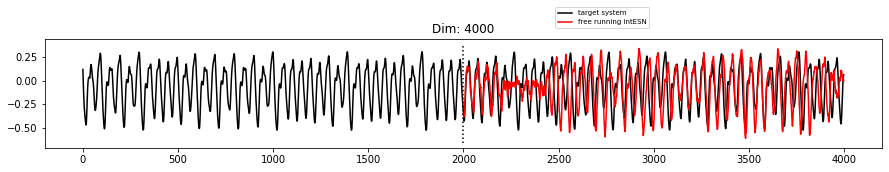

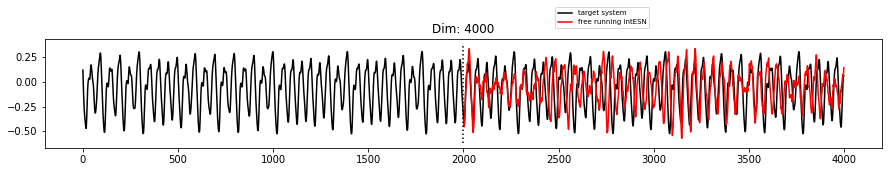

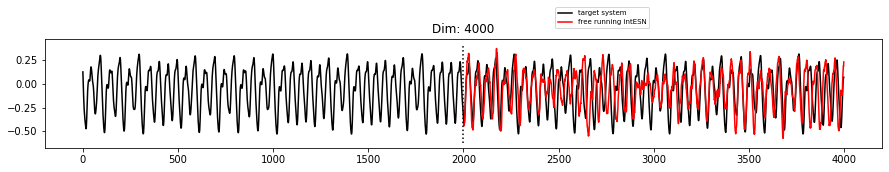

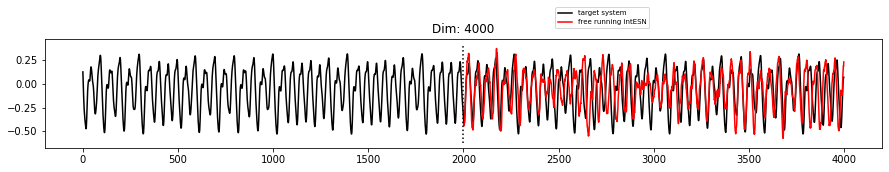

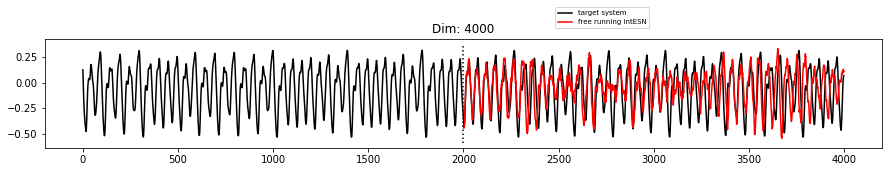

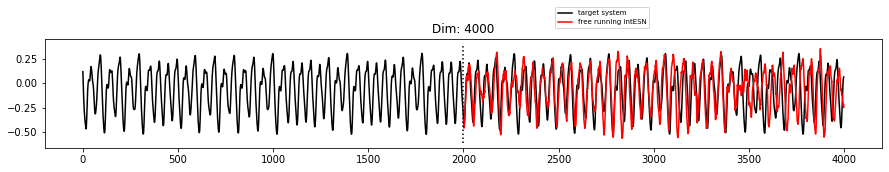

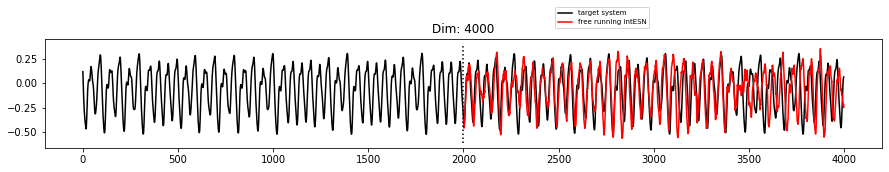

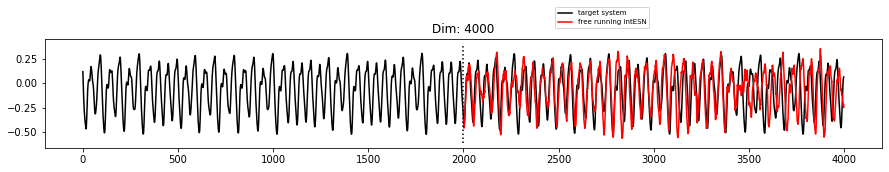

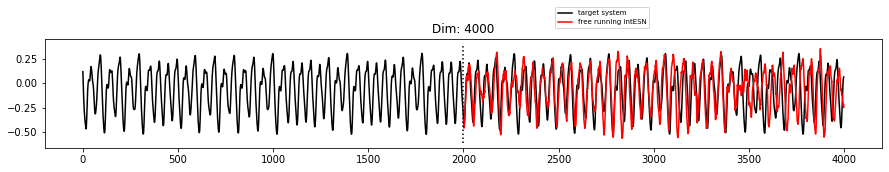

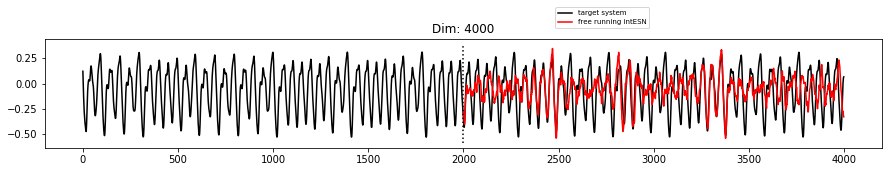

test error: 
tensor(0.2154, device='cuda:0')


In [ ]:

data = np.load('/content/mackey_glass_t17.npy')
trainlen = 2000
future = 2000
dims = [4000] #100, 200, 400, 500, 800, 1000, 3000, 
cumulative = torch.ones((len(dims),)).to(device)
for ind, dim in enumerate(dims):
  best_preds = torch.ones(future).to(device)
  for run in range(10):
    one_hd = generate_random_hypervector(dim)

    def q_in(val):
      return torch.clone(one_hd)
    torch_data = torch.from_numpy(data).to(device)
    encoder = Encoder(dim=dim, 
                      y_max=data.max(), 
                      y_min=data.min(), 
                      sensitivity=200)

    esn = intESN(n_inputs = 1,
              n_outputs = 1,
              n_reservoir = dim,
              noise=0.001,
              clip=7,
              # q_in = encoder.quantized_encode,
              q_in = q_in,
              q_out = encoder.quantized_encode,
              )
    input = torch.ones((trainlen,1)).to(device)
    outputs = torch_data[:trainlen]
    pred_training = esn.fit(input, outputs)

    prediction = esn.predict(torch.ones(future).to(device), continuation=True)
    error = torch.sqrt(torch.mean((prediction.flatten() - torch_data[trainlen:trainlen+future])**2)).item()
    if error < cumulative[ind]:
      best_preds = prediction
      cumulative[ind] = error
    plt.figure(figsize=(15,2))
    plt.plot(range(0,trainlen+future),torch_data[0:trainlen+future].cpu(),'k',label="target system")
    plt.plot(range(trainlen,trainlen+future), best_preds.cpu() ,'r', label="free running intESN")
    lo,hi = plt.ylim()
    plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:')
    plt.legend(loc=(0.61,1.1),fontsize='x-small')
    plt.title('Dim: ' + str(dim))
    plt.show()
  print("test error: \n"+str(cumulative[ind]))

# Time analysis

In [ ]:
import time
from tqdm import tqdm
data = np.load('/content/mackey_glass_t17.npy')
dims = [50, 75, 100, 150, 200, 250, 300, 400, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000, 8000, 10000] #, 20000, 40000, 50000, 100000
trainlen = 2000
future = 200

times_reg = np.zeros((len(dims), 1))
for i, dim in tqdm(enumerate(dims)):
    start = time.time()
    esn = ESN(n_inputs = 1,
              n_outputs = 1,
              n_reservoir = dim,
              spectral_radius = 1.5,
              random_state=42)
    pred_training = esn.fit(np.ones(trainlen),data[:trainlen])
    prediction = esn.predict(np.ones(future))
    times_reg[i] = time.time() - start

torch_data = torch.from_numpy(data).to(device)
times_int = np.zeros((len(dims), 1))
input = torch.ones((trainlen,1)).to(device)
outputs = torch_data[:trainlen]
for i, dim in tqdm(enumerate(dims)):
    start = time.time()
    encoder = Encoder(dim=dim, 
                      y_max=data.max()*1.1, 
                      y_min=data.min()*1.1 if data.min() < 0 else data.min()*0.9, 
                      sensitivity=200)
    one_hd = generate_random_hypervector(dim)

    def q_in(val):
      return torch.clone(one_hd)
    esn = intESN(n_inputs = 1,
              n_outputs = 1,
              n_reservoir = dim,
              noise=0.001,
              clip=7,
              q_in = q_in,
              q_out = encoder.quantized_encode,
              )
    pred_training = esn.fit(input, outputs)
    prediction = esn.predict(torch.ones(future).to(device), continuation=True)
    times_int[i] = time.time() - start

18it [10:38, 35.46s/it] 
18it [00:14,  1.23it/s]


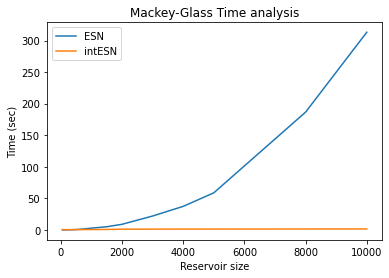

In [ ]:
plt.plot(dims, times_reg, label='ESN')
plt.plot(dims, times_int, label='intESN')
plt.xlabel('Reservoir size')
plt.ylabel('Time (sec)')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.title('Mackey-Glass Time analysis')
plt.show()